<a id="toc"></a>
# M1 mirror system redesign

[rafael.celestre@synchrotron-soleil.fr](mailto:rafael.celestre@synchrotron-soleil.fr)

Contents :
1. [Reflection spectra of commonly used coatings](#reflec_curves)
1. [Coating Candidates](#coating-candidates)

***

In [1]:
__author__ = ['Rafael Celestre']
__contact__ = 'rafael.celestre@synchrotron-soleil.fr'
__license__ = 'GPL-3.0'
__copyright__ = 'Synchrotron SOLEIL, Saint Aubin, France'
__created__ = '21/05/2024'
__changed__ = '14/11/2024'

import sys

import numpy as np
from barc4plots.barc4plots import PlotManager
from barc4xoc.materials import reflectivity_curve, reflectivity_map, combine_mirrors
from barc4xoc.misc import energy_wavelength

# checking we are using the correct python:
print(sys.executable)
print(sys.version)

# benchmarking tools
# %load_ext autoreload
# %autoreload 2
# %matplotlib widget


c:\Users\rafae\miniconda3\envs\PyOptiX\python.exe
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]


<a id="reflec_curves"></a>
## Reflection spectra of commonly used coatings
[Back to the top](#toc)


In [ ]:
e0, ei, ef, dE = 0, 250, 5000, 5
ne = int((ef-ei)/dE)+1
energy = np.linspace(ei, ef, ne)

In [ ]:
theta0, thetai, thetaf, dtheta = 0.0, 0.25, 3.0, 0.01
ntheta = int((thetaf-thetai)/dtheta)+1
theta = np.linspace(thetai, thetaf, ntheta)
reflec_cutoff = 5/100

In [ ]:
mirror_length = 1/np.sin(np.deg2rad(theta))

fig = PlotManager()

fig.image, fig.x = mirror_length, theta
fig.additional_info("mirror length per beam unit size", "grazing angle [°]", "[mm/mm]", 
                    xmin=theta0, xmax=thetaf+(thetai-theta0), ymin=0, ymax=250).aesthetics(LaTex=True, grid=True).info_1d_plot(0).plot_1d()

In [ ]:
def plot_reflec_map(reflec_dict, reflec_cutoff=0, cm=4):
    
    reflec_map = reflec_dict["reflectivity"]
    if reflec_cutoff != 0:
        reflec_map[reflec_map<reflec_cutoff] = np.nan
    fig = PlotManager()
    fig.image, fig.x, fig.y = reflec_map, reflec_dict["energy"], reflec_dict["theta"]
    fig.additional_info(reflec_dict["material"], "energy [eV]", "grazing angle [°]", e0, ef+(ei-e0), theta0, thetaf+(thetai-theta0), 0, 1,
                        ).aesthetics(LaTex=True, grid=True, AspectRatio=False).info_2d_plot(cm).plot_2d()

### Low Z

In [ ]:
plot_reflec_map(reflectivity_map("B4C", 2.52, thetai, thetaf, ntheta, ei, ef, ne), reflec_cutoff)

### Low-ish Z

In [ ]:
plot_reflec_map(reflectivity_map("Si", -1, thetai, thetaf, ntheta, ei, ef, ne), reflec_cutoff)

### Intermediate Z

In [ ]:
plot_reflec_map(reflectivity_map("Mo", -1, thetai, thetaf, ntheta, ei, ef, ne), reflec_cutoff)

In [ ]:
plot_reflec_map(reflectivity_map("Rh", -1, thetai, thetaf, ntheta, ei, ef, ne), reflec_cutoff)

### High Z

In [ ]:
plot_reflec_map(reflectivity_map("Pt", -1, thetai, thetaf, ntheta, ei, ef, ne), reflec_cutoff)

<a id="coating_candidates"></a>
# Coating candidates
[Back to the top](#toc)

Incident angles should be (ideally) between $\theta=0.6°$ and 
$\theta=2.5°$.

In [ ]:
def plot_mirror_combinations(transmission, combination, energy, theta):
    
    fig = PlotManager()

    plot_configs = [
        {"index": k, "image": transmission[:, k], "x": energy, "hold": (k != 0),
        "title": f'{combination[k, 0]} $\\times$ {combination[k, 1]}',
        "enable": (k == transmission.shape[1] - 1)}
        for k in range(transmission.shape[1])]

    for config in plot_configs:
        fig.image, fig.x = config["image"], config["x"]
        fig.LabelPos = 0
        if config["index"] == 0:
            fig.additional_info(f'grazing angle @ {theta:.2f}°', "energy [eV]", "reflectivity", 
                                xmin=e0, xmax=8000+(ei-e0), ymin=-0.05, ymax=1.05).aesthetics(LaTex=True, grid=True)
        fig.info_1d_plot(config["index"], config["title"]).plot_1d(enable=config["enable"], hold=config["hold"])

In [ ]:
ei = 250
ef = 5000
ne = int((ef-ei)/0.2)

## M1A and M1B/C (low energy configuration)

In [ ]:
theta_scan = [2.0, 1.75, 1.5]

for theta in theta_scan:
    candidates = [reflectivity_curve("B4C", 2.52, theta, ei, ef, ne), 
                reflectivity_curve("Mo", -1, theta, ei, ef, ne),
                reflectivity_curve("Pt", -1, theta, ei, ef, ne)]
    transmission1, combination = combine_mirrors(candidates, 2)
    plot_mirror_combinations(transmission1, combination, np.linspace(ei, ef, ne), theta)

## M1A and M1B/C (high energy configuration)

In [ ]:
theta_scan = [0.85, 0.8, 0.75, 0.44]

for theta in theta_scan:
    candidates = [reflectivity_curve("B4C", 2.52, theta, ei, ef, ne), 
                reflectivity_curve("Mo", -1, theta, ei, ef, ne),
                reflectivity_curve("Pt", -1, theta, ei, ef, ne)]
    transmission1, combination = combine_mirrors(candidates, 2)
    plot_mirror_combinations(transmission1, combination, np.linspace(ei, ef, ne), theta)

## BOREAS type solution

In [ ]:
ei = 250
ef = 5000
ne = int((ef-ei)/0.2)

c1 = reflectivity_curve("Au", -1, 1.0, ei, ef, ne)
c2 = reflectivity_curve("Ni", -1, 1.0, ei, ef, ne)
c3 = reflectivity_curve("Au", -1, 1.15, ei, ef, ne)

In [ ]:
fig.image, fig.x = c1["reflectivity"]*c3["reflectivity"], c1["energy"]
fig.additional_info("M1 (BOREAS)", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, f'{c1["material"]} @ {c1["theta"]}° $\\times$ {c3["material"]} @ {c3["theta"]}°').plot_1d(enable=False)
fig.image, fig.x = c2["reflectivity"]*c3["reflectivity"], c1["energy"]
fig.info_1d_plot(1, f'{c2["material"]} @ {c2["theta"]}° $\\times$ {c3["material"]} @ {c3["theta"]}°').plot_1d(enable=True, hold=True)

In [11]:
e0 = 0
ei = 20
ef = 100
ne = int((ef-ei)/0.2)

c1 = reflectivity_curve("Si", -1, 20, ei, ef, ne)

Density for Si (Z=14):  2.330 g/cm3
f1f2_calc: using density: 2.330000 g/cm3


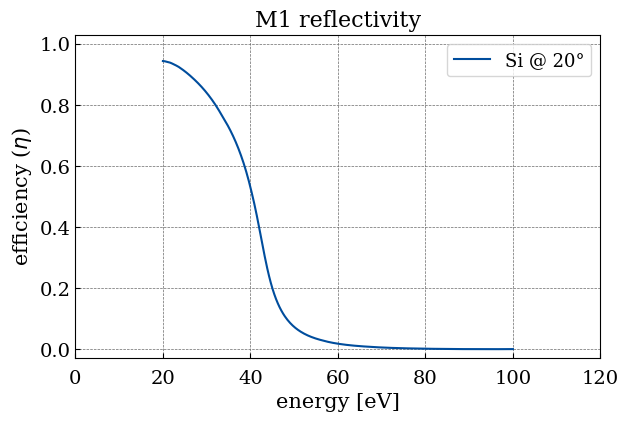

In [12]:
fig = PlotManager()
fig.image, fig.x = c1["reflectivity"], c1["energy"]
fig.additional_info("M1 reflectivity", "energy [eV]", "efficiency ($\eta$)", xmin=e0, xmax=ef+(ei-e0), ymin=-0.03, ymax=1.03).aesthetics(LaTex=True, grid=True)
fig.info_1d_plot(0, f'{c1["material"]} @ {c1["theta"]}°').plot_1d(enable=True)